In [1]:
import os
from google.colab import drive

# 1. اتصال به گوگل درایو
drive.mount('/content/drive')

# 2. آدرس فایل زیپ در درایو و آدرس مقصد
zip_path = "/content/drive/MyDrive/data.zip"
extract_path = "/content/temp_dataset"

# 3. استخراج فایل (Unzip)
if not os.path.exists(extract_path):
    print("در حال استخراج فایل‌ها... لطفا صبر کنید")
    !unzip -q "$zip_path" -d "$extract_path"
    print("استخراج تمام شد!")
else:
    print("فایل‌ها قبلاً استخراج شده‌اند.")

# بررسی اینکه پوشه‌ها درست هستند
print("محتویات پوشه:")
print(os.listdir(os.path.join(extract_path, 'data')))

Mounted at /content/drive
در حال استخراج فایل‌ها... لطفا صبر کنید
استخراج تمام شد!
محتویات پوشه:
['validation', 'train']


In [10]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [11]:
# ==========================================
# 1. Setup Paths (For Google Colab Environment)
# ==========================================
# Assuming the zip file was extracted to /content/temp_dataset
BASE_DIR = "/content/temp_dataset/data"
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'validation')

# Output paths
MODEL_SAVE_PATH = '/content/emotion_model.h5'
PLOT_SAVE_PATH = '/content/training_history.png'

# Hyperparameters
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 7

In [12]:
# ==========================================
# 2. Data Preparation & Augmentation
# ==========================================
# Apply data augmentation to training data to prevent overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=20,       # Random rotation
    width_shift_range=0.1,   # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.1,         # Shear transformation
    zoom_range=0.1,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    fill_mode='nearest'
)

# Only rescale validation data (do not augment validation data)
val_datagen = ImageDataGenerator(rescale=1./255)

print(f"[INFO] Reading Training images from: {TRAIN_DIR}")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",  # Using Grayscale images
    class_mode='categorical',
    shuffle=True
)

print(f"[INFO] Reading Validation images from: {VAL_DIR}")
validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False
)

[INFO] Reading Training images from: /content/temp_dataset/data/train
Found 28821 images belonging to 7 classes.
[INFO] Reading Validation images from: /content/temp_dataset/data/validation
Found 7066 images belonging to 7 classes.


In [13]:
# ==========================================
# 3. CNN Model Architecture
# ==========================================
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 4 (Extra depth for better accuracy)
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# ==========================================
# 4. Callbacks (Training Control)
# ==========================================
callbacks = [
    # Save only the best model based on validation accuracy
    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),

    # Reduce learning rate if validation loss stops improving
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=1e-5),

    # Stop training if no improvement after 12 epochs
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
]

In [15]:
# ==========================================
# 5. Start Training
# ==========================================
print(f"\n[INFO] Starting training for {EPOCHS} epochs...")

history = model.fit(
    train_generator,
    # Using len() ensures we run through the entire dataset without skipping
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks
)



[INFO] Starting training for 50 epochs...
Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2154 - loss: 2.4419
Epoch 1: val_accuracy improved from -inf to 0.27385, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 55s 91ms/step - accuracy: 0.2155 - loss: 2.4412 - val_accuracy: 0.2738 - val_loss: 1.7537 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3347 - loss: 1.7354
Epoch 2: val_accuracy improved from 0.27385 to 0.46759, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - accuracy: 0.3348 - loss: 1.7352 - val_accuracy: 0.4676 - val_loss: 1.4101 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4382 - loss: 1.4661
Epoch 3: val_accuracy improved from 0.46759 to 0.49943, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.4382 - loss: 1.4660 - val_accuracy: 0.4994 - val_loss: 1.3243 - learning_rate: 0.0010
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4968 - loss: 1.3078
Epoch 4: val_accuracy improved from 0.49943 to 0.54585, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.4968 - loss: 1.3078 - val_accuracy: 0.5459 - val_loss: 1.1933 - learning_rate: 0.0010
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5284 - loss: 1.2318
Epoch 5: val_accuracy improved from 0.54585 to 0.55534, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.5284 - loss: 1.2318 - val_accuracy: 0.5553 - val_loss: 1.1524 - learning_rate: 0.0010
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5467 - loss: 1.1980
Epoch 6: val_accuracy did not improve from 0.55534
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.5467 - loss: 1.1980 - val_accuracy: 0.5464 - val_loss: 1.1960 - learning_rate: 0.0010
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5600 - loss: 1.1624
Epoch 7: val_accuracy improved from 0.55534 to 0.59256, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.5600 - loss: 1.1623 - val_accuracy: 0.5926 - val_loss: 1.0801 - learning_rate: 0.0010
Epoch 8/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5703 - loss: 1.1274
Epoch 8: val_accuracy did not improve from 0.59256
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.5703 - loss: 1.1275 - val_accuracy: 0.5835 - val_loss: 1.1161 - learning_rate: 0.0010
Epoch 9/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5853 - loss: 1.1033
Epoch 9: val_accuracy improved from 0.59256 to 0.60742, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.5853 - loss: 1.1033 - val_accuracy: 0.6074 - val_loss: 1.0523 - learning_rate: 0.0010
Epoch 10/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5853 - loss: 1.0856
Epoch 10: val_accuracy did not improve from 0.60742
451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5853 - loss: 1.0856 - val_accuracy: 0.5822 - val_loss: 1.0908 - learning_rate: 0.0010
Epoch 11/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5991 - loss: 1.0654
Epoch 11: val_accuracy improved from 0.60742 to 0.61067, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.5991 - loss: 1.0654 - val_accuracy: 0.6107 - val_loss: 1.0376 - learning_rate: 0.0010
Epoch 12/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6011 - loss: 1.0648
Epoch 12: val_accuracy did not improve from 0.61067
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.6011 - loss: 1.0648 - val_accuracy: 0.5897 - val_loss: 1.0929 - learning_rate: 0.0010
Epoch 13/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6085 - loss: 1.0476
Epoch 13: val_accuracy did not improve from 0.61067
451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.6085 - loss: 1.0476 - val_accuracy: 0.5877 - val_loss: 1.1129 - learning_rate: 0.0010
Epoch 14/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6090 - loss: 1.0424
Epoch 14: val_accuracy improved from 0.61067 to 0.61902, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.6090 - loss: 1.0424 - val_accuracy: 0.6190 - val_loss: 1.0261 - learning_rate: 0.0010
Epoch 15/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6112 - loss: 1.0346
Epoch 15: val_accuracy improved from 0.61902 to 0.62298, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.6112 - loss: 1.0346 - val_accuracy: 0.6230 - val_loss: 1.0197 - learning_rate: 0.0010
Epoch 16/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6263 - loss: 0.9992
Epoch 16: val_accuracy improved from 0.62298 to 0.63770, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.6263 - loss: 0.9992 - val_accuracy: 0.6377 - val_loss: 0.9723 - learning_rate: 0.0010
Epoch 17/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6317 - loss: 0.9822
Epoch 17: val_accuracy did not improve from 0.63770
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.6317 - loss: 0.9822 - val_accuracy: 0.6008 - val_loss: 1.0765 - learning_rate: 0.0010
Epoch 18/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6342 - loss: 0.9726
Epoch 18: val_accuracy did not improve from 0.63770
451/451 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.6342 - loss: 0.9726 - val_accuracy: 0.6228 - val_loss: 1.0134 - learning_rate: 0.0010
Epoch 19/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6433 - loss: 0.9541
Epoch 19: val_accuracy improved from 0.63770 to 0.65398, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.6433 - loss: 0.9541 - val_accuracy: 0.6540 - val_loss: 0.9519 - learning_rate: 0.0010
Epoch 20/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6429 - loss: 0.9436
Epoch 20: val_accuracy did not improve from 0.65398
451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.6429 - loss: 0.9436 - val_accuracy: 0.6352 - val_loss: 1.0066 - learning_rate: 0.0010
Epoch 21/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6503 - loss: 0.9382
Epoch 21: val_accuracy did not improve from 0.65398
451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.6503 - loss: 0.9382 - val_accuracy: 0.6378 - val_loss: 0.9783 - learning_rate: 0.0010
Epoch 22/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6501 - loss: 0.9313
Epoch 22: val_accuracy did not improve from 0.65398
451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.6501 - loss: 0.9313 - val_accuracy: 0.6482 - val_loss: 0.9634 - learning_rate: 0.0010
Epoch 23

451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.6696 - loss: 0.8853 - val_accuracy: 0.6691 - val_loss: 0.8966 - learning_rate: 2.0000e-04
Epoch 25/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6907 - loss: 0.8403
Epoch 25: val_accuracy improved from 0.66912 to 0.67365, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.6907 - loss: 0.8404 - val_accuracy: 0.6736 - val_loss: 0.8880 - learning_rate: 2.0000e-04
Epoch 26/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6840 - loss: 0.8483
Epoch 26: val_accuracy did not improve from 0.67365
451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.6840 - loss: 0.8483 - val_accuracy: 0.6676 - val_loss: 0.8950 - learning_rate: 2.0000e-04
Epoch 27/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6901 - loss: 0.8339
Epoch 27: val_accuracy improved from 0.67365 to 0.67506, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.6901 - loss: 0.8339 - val_accuracy: 0.6751 - val_loss: 0.8924 - learning_rate: 2.0000e-04
Epoch 28/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6893 - loss: 0.8414
Epoch 28: val_accuracy improved from 0.67506 to 0.67860, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.6893 - loss: 0.8414 - val_accuracy: 0.6786 - val_loss: 0.8852 - learning_rate: 2.0000e-04
Epoch 29/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6926 - loss: 0.8178
Epoch 29: val_accuracy did not improve from 0.67860
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.6926 - loss: 0.8178 - val_accuracy: 0.6785 - val_loss: 0.8798 - learning_rate: 2.0000e-04
Epoch 30/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7021 - loss: 0.8042
Epoch 30: val_accuracy did not improve from 0.67860
451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.7021 - loss: 0.8042 - val_accuracy: 0.6751 - val_loss: 0.8927 - learning_rate: 2.0000e-04
Epoch 31/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6945 - loss: 0.8124
Epoch 31: val_accuracy improved from 0.67860 to 0.68341, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.6945 - loss: 0.8124 - val_accuracy: 0.6834 - val_loss: 0.8822 - learning_rate: 2.0000e-04
Epoch 32/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7019 - loss: 0.7960
Epoch 32: val_accuracy did not improve from 0.68341
451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.7019 - loss: 0.7960 - val_accuracy: 0.6827 - val_loss: 0.8807 - learning_rate: 2.0000e-04
Epoch 33/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7020 - loss: 0.7976
Epoch 33: val_accuracy did not improve from 0.68341

Epoch 33: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.7020 - loss: 0.7976 - val_accuracy: 0.6809 - val_loss: 0.8809 - learning_rate: 2.0000e-04
Epoch 34/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7067 - loss: 0.7822
Epoch 34: val_accuracy did not improve from 0.68341
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.706

451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.7095 - loss: 0.7753 - val_accuracy: 0.6848 - val_loss: 0.8755 - learning_rate: 4.0000e-05
Epoch 36/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7062 - loss: 0.7874
Epoch 36: val_accuracy improved from 0.68483 to 0.68539, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.7062 - loss: 0.7874 - val_accuracy: 0.6854 - val_loss: 0.8749 - learning_rate: 4.0000e-05
Epoch 37/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7121 - loss: 0.7718
Epoch 37: val_accuracy did not improve from 0.68539
451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.7121 - loss: 0.7718 - val_accuracy: 0.6847 - val_loss: 0.8777 - learning_rate: 4.0000e-05
Epoch 38/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7125 - loss: 0.7775
Epoch 38: val_accuracy did not improve from 0.68539
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.7125 - loss: 0.7774 - val_accuracy: 0.6844 - val_loss: 0.8763 - learning_rate: 4.0000e-05
Epoch 39/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7136 - loss: 0.7678
Epoch 39: val_accuracy did not improve from 0.68539
451/451 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.7136 - loss: 0.7678 - val_accuracy: 0.6833 - val_loss: 0.8796 - learning_rate: 4.0


Epoch 40: ReduceLROnPlateau reducing learning rate to 1e-05.
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.7162 - loss: 0.7695 - val_accuracy: 0.6867 - val_loss: 0.8763 - learning_rate: 4.0000e-05
Epoch 41/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7184 - loss: 0.7646
Epoch 41: val_accuracy did not improve from 0.68667
451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.7183 - loss: 0.7647 - val_accuracy: 0.6858 - val_loss: 0.8752 - learning_rate: 1.0000e-05
Epoch 42/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7150 - loss: 0.7703
Epoch 42: val_accuracy did not improve from 0.68667
451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.7150 - loss: 0.7703 - val_accuracy: 0.6864 - val_loss: 0.8751 - learning_rate: 1.0000e-05
Epoch 43/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7118 - loss: 0.7611
Epoch 43: val_accuracy improved from 0.68667 to 0.68780, saving model to /content/emotion_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.7118 - loss: 0.7611 - val_accuracy: 0.6878 - val_loss: 0.8746 - learning_rate: 1.0000e-05
Epoch 44/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7147 - loss: 0.7594
Epoch 44: val_accuracy did not improve from 0.68780
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.7147 - loss: 0.7594 - val_accuracy: 0.6872 - val_loss: 0.8758 - learning_rate: 1.0000e-05
Epoch 45/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7160 - loss: 0.7587
Epoch 45: val_accuracy did not improve from 0.68780
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.7160 - loss: 0.7588 - val_accuracy: 0.6864 - val_loss: 0.8760 - learning_rate: 1.0000e-05
Epoch 46/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7168 - loss: 0.7622
Epoch 46: val_accuracy did not improve from 0.68780
451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.7168 - loss: 0.7622 - val_accuracy: 0.6864 - val_loss: 0.8744 - learning_rate: 1.0

451/451 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.7164 - loss: 0.7599 - val_accuracy: 0.6885 - val_loss: 0.8752 - learning_rate: 1.0000e-05


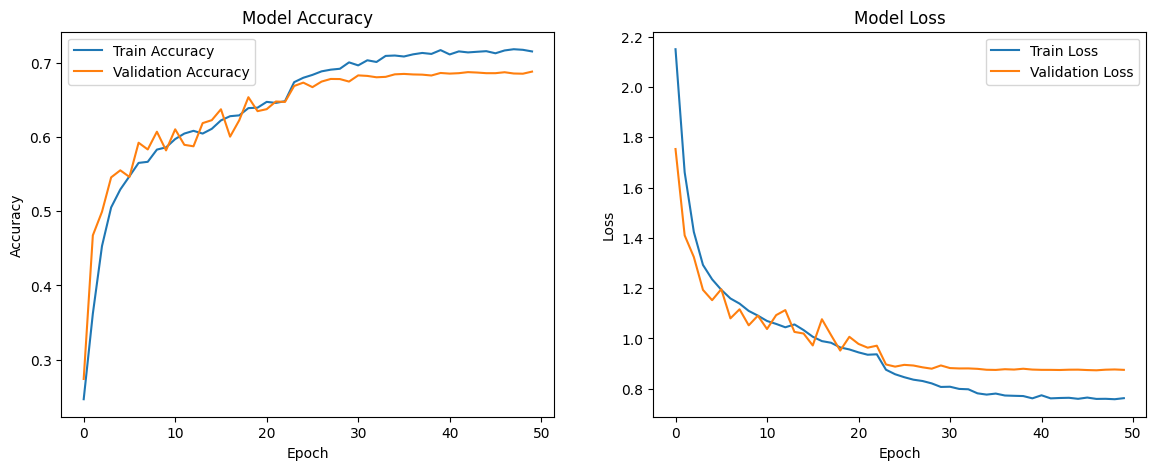


[INFO] Training Finished.
[INFO] Best model saved as: /content/emotion_model.h5


In [16]:
# ==========================================
# 6. Plot Results & Download
# ==========================================
# Plot Accuracy and Loss
plt.figure(figsize=(14, 5))

# Accuracy Subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss Subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Save plot
plt.savefig(PLOT_SAVE_PATH)
plt.show()

print("\n[INFO] Training Finished.")
print(f"[INFO] Best model saved as: {MODEL_SAVE_PATH}")

In [17]:
# Attempt to download files automatically
try:
    from google.colab import files
    files.download(MODEL_SAVE_PATH)
    files.download(PLOT_SAVE_PATH)
except Exception as e:
    print("[WARN] Automatic download failed. Please download files manually from the file explorer.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

In [19]:
# ==========================================
# 1. Setup & Load Model
# ==========================================
# Load the best trained model
model_path = '/content/emotion_model.h5'
print("[INFO] Loading best model...")
model = load_model(model_path)

# Class labels
class_labels = list(validation_generator.class_indices.keys())
print(f"[INFO] Class Labels: {class_labels}")

[INFO] Loading best model...


[INFO] Class Labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


[INFO] Evaluating on Validation Set...
111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry       0.60      0.60      0.60       960
     disgust       0.76      0.59      0.66       111
        fear       0.59      0.42      0.49      1018
       happy       0.88      0.90      0.89      1825
     neutral       0.59      0.74      0.66      1216
         sad       0.56      0.58      0.57      1139
    surprise       0.81      0.74      0.77       797

    accuracy                           0.69      7066
   macro avg       0.69      0.65      0.66      7066
weighted avg       0.69      0.69      0.69      7066



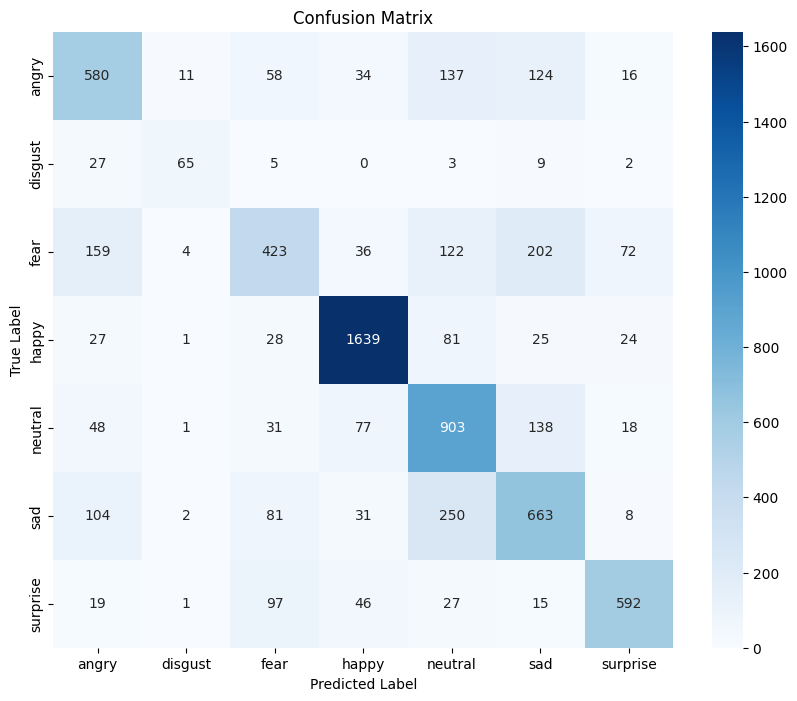

In [20]:
# ==========================================
# 2. Quantitative Evaluation (Confusion Matrix)
# ==========================================
print("[INFO] Evaluating on Validation Set...")

# Reset generator to start to ensure order is correct
validation_generator.reset()

# Get predictions for all validation images
# verbose=1 shows a progress bar
predictions = model.predict(validation_generator, steps=len(validation_generator), verbose=1)

# Convert probabilities to class index (e.g., [0.1, 0.9, ...] -> 1)
y_pred = np.argmax(predictions, axis=1)

# Get true labels from the generator
y_true = validation_generator.classes

# --- Classification Report ---
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_labels))

# --- Confusion Matrix Plot ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/confusion_matrix.png') # Save for your report
plt.show()



[INFO] Showing sample predictions...


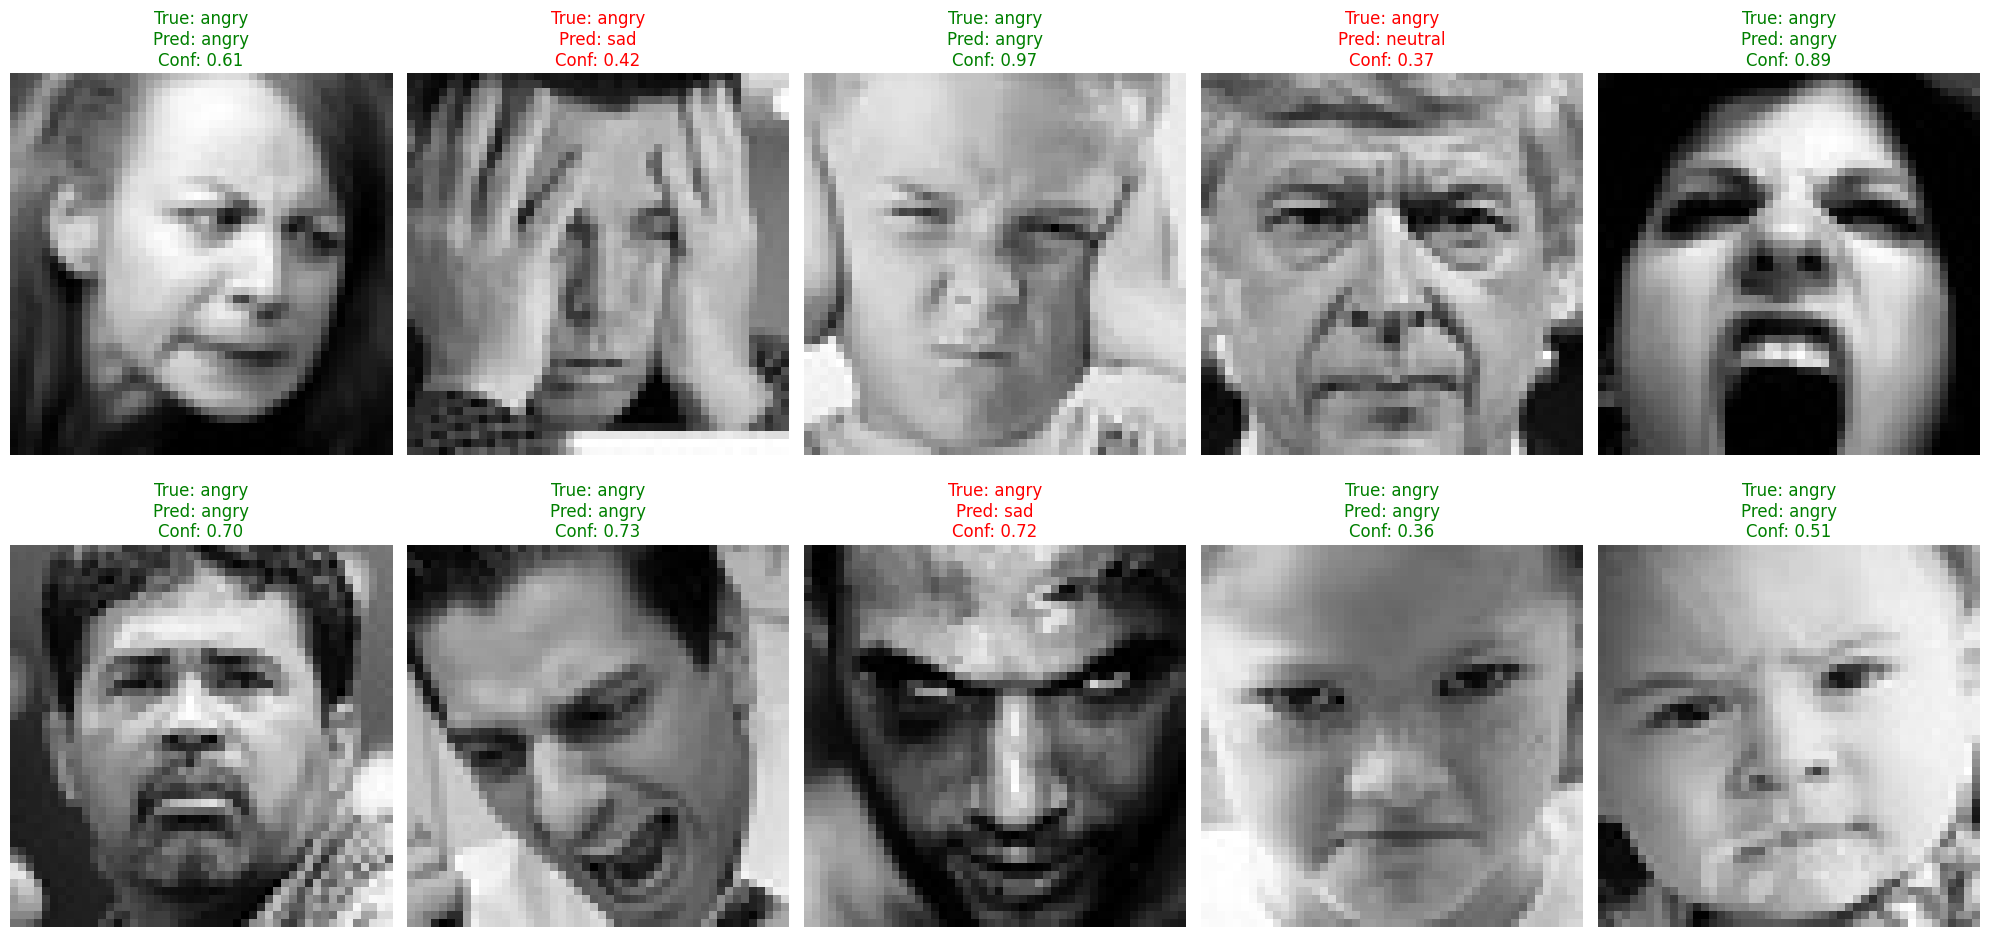

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# ==========================================
# 3. Visual Testing (Sample Predictions)
# ==========================================
print("\n[INFO] Showing sample predictions...")

# Get a batch of images
x_batch, y_batch = next(validation_generator)
# Predict this batch
pred_batch = model.predict(x_batch, verbose=0)

# Show first 10 images from the batch
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Display image (convert back from grayscale if needed for display)
    img = x_batch[i].reshape(48, 48)
    plt.imshow(img, cmap='gray')

    # Get labels
    true_label = class_labels[np.argmax(y_batch[i])]
    pred_label = class_labels[np.argmax(pred_batch[i])]
    confidence = np.max(pred_batch[i])

    # Color: Green if correct, Red if wrong
    color = 'green' if true_label == pred_label else 'red'

    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.savefig('/content/sample_predictions.png') # Save for report
plt.show()

# Download the outputs for your report
try:
    from google.colab import files
    files.download('/content/confusion_matrix.png')
    files.download('/content/sample_predictions.png')
except:
    print("Please download images manually.")